# Title : predicting protein solubility 

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import os
import pandas as pd
import requests
import json
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error
import numpy as np

## DATASET CLEANING and Feature engineering

The dataset was taken from 

Title : predicting protein solubility 

data set used: eSOL: Solubility data for Ecoli proteins

    DOI: [10.18908/lsdba.nbdc00440-001](https://dbarchive.biosciencedbc.jp/en/esol/data-1.html)


In [34]:
dataset_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Dataset"
log_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\logs"
img_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Figuredump"
other_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\loos_dir"
d1 = pd.read_csv(os.path.join(dataset_dir, "esol.csv"))
print(d1.shape)

(4132, 28)


##### Initial dataset composition

(4132, 28)
Index(

       ['JW_ID', 'ECK number', 'B number', 'Gene name K-12', 'Locus name K-12','Synonyms of locus names K-12', 'Solubility (%)', 'Yield (uM)',

       'Yield (ug/ml)', 'Minus Sol (%)', 'TF Sol (%)', 'GroE Sol (%)','KJE Sol (%)', 'Minus Yield (uM)', 'TF Yield (uM)', 'GroE Yield (uM)',

       'KJE Yield (uM)', 'Minus Yield (ug/ml)', 'TF Yield (ug/ml)','GroE Yield (ug/ml)', 'KJE Yield (ug/ml)', 'Calculated MW (kDa)',

       'Calculated pI', 'Type of gene product', 'Gene product description','Cell location', 'Structure (PDB) ID', 'SCOP assignment'],

      dtype='object')


Okay first things first lets try and identify the dimensions that confer with solubility.

Deffo Solubility (%) will be our lable, so this needs to be non-NAN 
"Calculated MW (kDa)", "Calculated pI" these are features that will have direct impact on the solubility i think. We should use this.

biologically speeking, Yeild data('Yield (uM)','Yield (ug/ml)') will have some correlation with solubility but this may result in high correlation issues.

'Type of gene product', 'Cell location' These features may have some critical instance class bias as some classes of proteins may be less expressable(less soluble)  lets keep this for future use.

In [35]:
lable = "Solubility (%)"
crit_col = ["Calculated MW (kDa)", "Calculated pI"]
adicols = ["Yield (uM)", "Yield (ug/ml)"]
assaycols = ["JW_ID","Solubility (%)","Calculated MW (kDa)", "Calculated pI","Yield (uM)", "Yield (ug/ml)"]
optional_cols = ["Type of gene product", "Cell location"]   #domain knowledge for further analysis

n Tot insatnce: 4132
- n NAN per col 
- Solubility (%)          959
- Calculated MW (kDa)       0
- Calculated pI             0
- Yield (uM)              959
- Yield (ug/ml)           959
- Type of gene product      0
- Cell location             2
- dtype: int64

% of NAN per col
- Solubility (%)          0.232091
- Calculated MW (kDa)     0.000000
- Calculated pI           0.000000
- Yield (uM)              0.232091
- Yield (ug/ml)           0.232091
- Type of gene product    0.000000
- Cell location           0.000484
- dtype: float64

instances with complete data for critical columns

- n Logical test ok instances:  3173
- % Logical test ok instances: 0.7679090029041626

array([[<Axes: title={'center': 'Solubility (%)'}>,
        <Axes: title={'center': 'Calculated MW (kDa)'}>],
       [<Axes: title={'center': 'Calculated pI'}>,
        <Axes: title={'center': 'Yield (uM)'}>],
       [<Axes: title={'center': 'Yield (ug/ml)'}>, <Axes: >]],
      dtype=object)

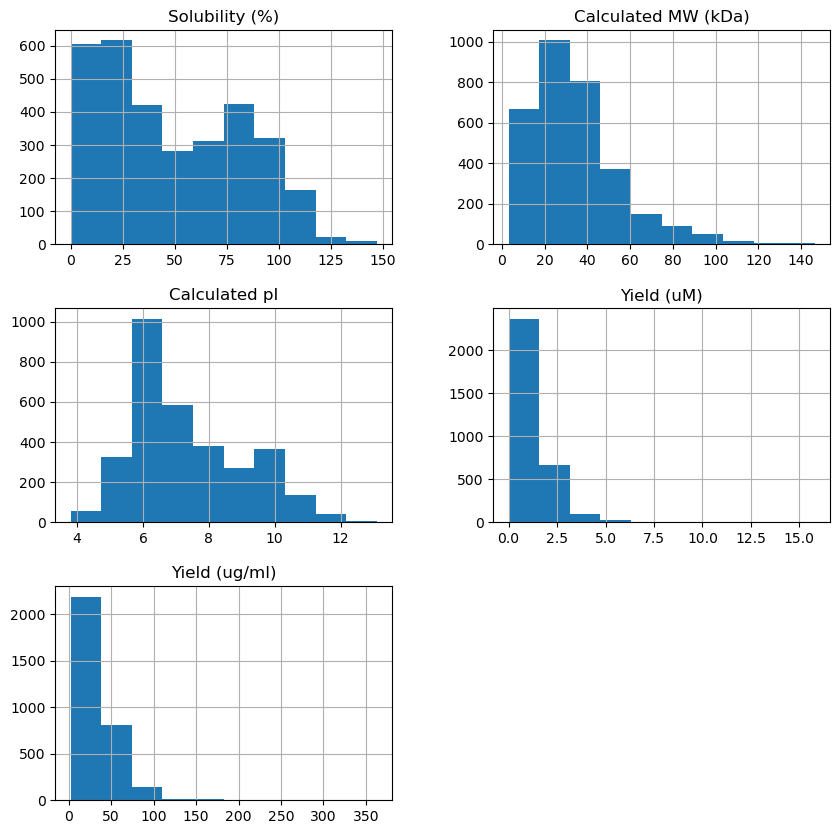

In [36]:
# first we need the lable.. so 
cdf = d1.dropna(subset=lable).copy()            #complete lable df shape: (3173, 28)
# next need to check for critical column integrity
# print(cdf[crit_col].isna().sum())               # no missing vals
# print(cdf[adicols].isna().sum())                # no missing vals
# final clean shape = 3173,28

assaydf = cdf[assaycols].copy()                 #(3173, 5)
assaydf.describe()
assaydf.hist(figsize=(10, 10))


Now we need to fetch the Sequence data matching the instances. 

Thankfully, the jw_id seems to match the Uniprot DB, so we will do some data crawling
first check the identifier that we are looking for...

In [37]:
Targ_ULR = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "JW2231",
    "format": "json",   # full JSON
}

response = requests.get(Targ_ULR, params=params)
print("Status:", response.status_code)

data = response.json()
with open(os.path.join(other_dir, "UNIPROTfetchJson.json"), "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)

Status: 200


            "sequence": {
                "value": "MAVSAKYDEFNHWWATEGDWVEEPNYRRNGMSGVQCVERNGKKLYVKRMTHHLFHSVRYPFGRPTIVREVAVIKELERAGVIVPKIVFGEAVKIEGEWRALLVTEDMAGFISIADWYAQHAVSPYSDEVRQAMLKAVALAFKKMHSINRQHGCCYVRHIYVKTEGNAEAGFLDLEKSRRRLRRDKAINHDFRQLEKYLEPIPKADWEQVKAYYYAM",
                "length": 216,
                "molWeight": 25296,
                "crc64": "49B8E72F553113FD",
                "md5": "B5EC566BFBE36672B78744D86C0B9E27"
            },
This is the part that we are interested in.   Now lets just extract this bit..

In [38]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None, "JW_ID is NaN"

    query = f"{jw_id} AND organism_id:83333"            #for Ecoli12
    
    params = {
        "query": query,
        "fields": "accession,id,gene_names,organism_id,sequence",
        "format": "tsv",
        "size": 5
    }

    try:
        r = requests.get(Targ_ULR, params=params)

        if r.status_code != 200:
            return None, f"HTTP {r.status_code}: {r.text[:200]}"

        text = r.text.strip()
        if not text:
            return None, "Empty response"

        lines = text.splitlines()
        if len(lines) <= 1:
            return None, "No hits"

        header = lines[0].split("\t")
        if "Sequence" not in header:
            return None, f"'Sequence' column missing. Header={header}"

        seq_idx = header.index("Sequence")
        first = lines[1].split("\t")
        seq = first[seq_idx]

        if seq == "":
            return None, "Empty sequence"

        return seq, None

    except Exception as e:
        return None, f"Exception: {str(e)}"


def add_sequences_with_progress(indf,id_col="JW_ID",sleep_sec=0.1,writemode="ON",dropmode="ON"):
    """
    indf:      type = df :: contianing the id
    id_col:    search target 
    writemode: "ON"  = write new seq col
               "OFF" = id-Seq mapping df 

    dropmode:  "ON"  = Drops instances with UniProt_seq = NaN ( only works when Writemode = on )
               "OFF" = keep NAN as NAN 
    """
    df = indf.copy()
    df["UniProt_seq"] = None
    unique_ids = df[id_col].dropna().unique()
    total = len(unique_ids)

    id_to_seq = {}
    error_log = []

    for i, jw in enumerate(unique_ids, start=1):
        seq, err = fetch_uniprot_seq_by_jw(jw)
        if err is None:
            id_to_seq[jw] = seq
            print(f"[{i}/{total}] {jw}: OK")
        else:
            id_to_seq[jw] = None
            print(f"[{i}/{total}] {jw}: FAIL → {err}")
            error_log.append({id_col: jw, "Error": err})
        time.sleep(sleep_sec)

    seq_df = pd.DataFrame([{id_col: jw, "UniProt_seq": id_to_seq.get(jw)}for jw in unique_ids])
    # dict for loop in pd.DATAFRAME to contsruct...
    
    #logging er
    err_df = pd.DataFrame(error_log)
    wmode = str(writemode).upper()
    dmode = str(dropmode).upper()

    if wmode == "ON":
        df["UniProt_seq"] = df[id_col].map(id_to_seq)

        if dmode == "ON":
            df = df.dropna(subset=["UniProt_seq"]).copy()
        main_df = df

    else:
        main_df = seq_df
    return main_df, seq_df, id_to_seq, err_df

# seq_map_df, _, id_to_seq, err_df = add_sequences_with_progress(assaydf,id_col="JW_ID",writemode="OFF",dropmode="OFF")


In [39]:
# assaydf_seq, seq_map_df, id_to_seq, err_df = add_sequences_with_progress(assaydf,id_col="JW_ID",writemode="ON",dropmode="ON")
print("DONE!")

DONE!


In [40]:
# assaydf_seq.to_csv(os.path.join(dataset_dir, "esolc_with_sequences.csv"), index=False)
# seq_map_df.to_csv(os.path.join(dataset_dir, "seq-jwidmap.csv"), index=False)
# err_df.to_csv(os.path.join(log_dir, "uniprot_sequence_errors.csv"), index=False)


assaydf_seq = pd.read_csv(os.path.join(dataset_dir,"esolc_with_sequences.csv"))

##### final dataset after cleaning : assaydf_seq

# now to Feature Engineering
##### Basic features
- Length
- 20 AA fractional composition (20개)
- Residue group fractions
- frac_pos = (K+R+H)/L
- frac_neg = (D+E)/L
- frac_charged = (K+R+H+D+E)/L
- frac_polar = (S+T+N+Q+Y+C)/L
- frac_hydrophobic = (A+V+L+I+M+F+W+Y)/L
- frac_aromatic = (F+W+Y)/L
- frac_turn = (N+G+P+S)/L
##### Extended features
- GRAVY
- Aliphatic index
- Aromaticity index
- Instability index
- Net charge at pH 7



In [41]:
# Parameters


AA20 = list("ACDEFGHIKLMNPQRSTVWY")
# Kyte–Doolittle hydropathy index (for GRAVY)
KD = {"A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3}
# pKa values for net charge at pH 7 (very standard approximations)
PKA_N_TERM = 9.6
PKA_C_TERM = 2.4
PKA_SIDE = {"D": 4.0,"E": 4.4,"H": 6.5,"C": 8.5,
            "Y": 10.0,"K": 10.5,"R": 12.5,}

vdw_radii = {"H": 1.20,"C": 1.70,"N": 1.55,"O": 1.52,"F": 1.47,
    "P": 1.80,"S": 1.80,"Cl": 1.75,"Br": 1.85,"I": 1.98,"B": 1.92,
    "Si": 2.10,"Se": 1.90,"Zn": 1.39,"Cu": 1.40,"Fe": 1.32,"Mg": 1.73,
    "Na": 2.27,"K": 2.75,"Ca": 2.31,}
#three are different vdw quantifications depending on the system but for our case
#its likely that we wont usethem. but this dict is based on the  Bondi VdW radii (Å)

In [42]:
import math
import pandas as pd

def henderson_hasselbalch_acid(pH, pKa):        #deprotonation for DECY
    return 1.0 / (1.0 + 10 ** (pKa - pH))

def henderson_hasselbalch_base(pH, pKa):        #deprotonation for KRH
    return 1.0 / (1.0 + 10 ** (pH - pKa))

def seq_to_features(seq, pH=7.0):           # feat dict 
    if not isinstance(seq, str):            # error guard
        return None, "Sequence is not a string"

    seq = seq.strip().upper()
    clean = [aa for aa in seq if aa in AA20]
    qlen = len(clean)

    if qlen == 0:
        return None, "Sequence contains no valid amino acids (length=0)"

    try:
        counts = {aa: 0 for aa in AA20}     # initialisiong count dict
        for aa in clean:
            counts[aa] += 1

        fracs = {aa: counts[aa] / qlen for aa in AA20}      # fracctionating or getting %
        pos_set = set("KRH")                                # converting to single str per physical chars.
        neg_set = set("DE")
        charged_set = set("KRHDE")
        polar_set = set("STNQYC")
        hydrophobic_set = set("AVLIMFWY")
        aromatic_set = set("FWY")
        turn_set = set("NGPS")

        frac_pos = sum(fracs[a] for a in pos_set)           
        frac_neg = sum(fracs[a] for a in neg_set)
        frac_charged = sum(fracs[a] for a in charged_set)
        frac_polar = sum(fracs[a] for a in polar_set)
        frac_hydrophobic = sum(fracs[a] for a in hydrophobic_set)
        frac_aromatic = sum(fracs[a] for a in aromatic_set)
        frac_turn = sum(fracs[a] for a in turn_set)

        # gravy
        gravy = sum(KD[a] for a in clean) / qlen

        # aliphatic index
        xA = fracs["A"]
        xV = fracs["V"]
        xI = fracs["I"]
        xL = fracs["L"]

        aliphatic_index = 100.0 * (xA + 2.9*xV + 3.9*(xI + xL))     #PMID: 7462208

        # aromaticity index
        aromaticity_index = frac_aromatic

        # placeholder instability index : i noticed the calculations are quite complex for this we will come back to this later.
        instability_index = None            # PMID 2075190

        # net charge
        n_term_charge = henderson_hasselbalch_base(pH, PKA_N_TERM)
        c_term_charge = -henderson_hasselbalch_acid(pH, PKA_C_TERM)

        side_charge = 0.0
        for aa in clean:
            if aa in ("D","E","C","Y"):
                side_charge += -henderson_hasselbalch_acid(pH, PKA_SIDE[aa])
            elif aa in ("K","R","H"):
                side_charge += henderson_hasselbalch_base(pH, PKA_SIDE[aa])

        net_charge = n_term_charge + c_term_charge + side_charge

        # collect
        feats = {
            "length": qlen,
            "gravy": gravy,
            "aliphatic_index": aliphatic_index,
            "aromaticity_index": aromaticity_index,
            "instability_index": instability_index,
            "net_charge_pH7": net_charge,
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_charged": frac_charged,
            "frac_polar": frac_polar,
            "frac_hydrophobic": frac_hydrophobic,
            "frac_aromatic": frac_aromatic,
            "frac_turn": frac_turn
        }

        for aa in AA20:
            feats[f"aa_{aa}"] = fracs[aa]

        return feats, None

    except Exception as e:
        return None, f"Exception during feature extraction: {str(e)}"
    
def combdimensionmatrix(df, seq_col="UniProt_seq",extra_cols=list()):

    feat_rows = []
    idx_list = []
    error_log = []

    for idx, seq in df[seq_col].items():
        feats, err = seq_to_features(seq)

        if err is not None:
            error_log.append({"Index": idx, "Error": err})
            continue

        feat_rows.append(feats)
        idx_list.append(idx)

    X = pd.DataFrame(feat_rows, index=idx_list)

    if extra_cols is not None:
        extra = df.loc[idx_list, list(extra_cols)].copy()
        X = pd.concat([X, extra], axis=1)

    error_df = pd.DataFrame(error_log)

    return X, error_df

In [43]:
# Running

X, err_df = combdimensionmatrix(assaydf_seq,extra_cols=['Solubility (%)', 'Calculated MW (kDa)', 'Calculated pI','Yield (uM)', 'Yield (ug/ml)'])
#X.shape     #(3150, 38)

# The Actual ML model 

#### Planning the model


Although solubility is often treated as a binary attribute in many biochemical applications, in practice it is a continuous physicochemical property that spans a spectrum between fully soluble and completely insoluble, depending on environmental conditions. The original esol dataset provided contains the solubility report as a % demonstrating this gradual variation of solubility instead of a threshold classification. Regarding this project, it was concluded formulating the problem as a regression is more approprate based on 2 main reasons: 1. Formulating solubility in a classification task leads to substantial information loss due to the continuous experimental data being forced in to arbitrary categories; 2. to formulate this in to a classification, a decision has to be made regarding the thresholds, however, mayny different programs, laboratories will use different procedures and constants(or conditions) thus, it is difficult to justify a specific threshold. 

Regarding the regression model design, various models were considered ranging from OLS, Ridge, Lasso and non-linear models. Proteins and data generated from the sequence tends to exhibit substantial multicollinearity due to the given biophysical properties which makes regularised models particularly useful. However, biological data also exhibits high degree of noise and outliers. For this project, it was decided the baseline model will be constructed with the Ridge regression due to its properties of variance stabilisation and robust generalisation with minimum feature loss. Also, the Lasso was thought to be particularly non-benificial in this case due to the likelyhood of elimiating correlated aminoacid discriptors while Tree-based models were also thought as a relatively weak candidate in this situation due to the tendency to overfit small noises and also reduction in interpretability. Although lacking prior knowledge to ElasticNet model, this model was also thoguht to be worth testing along the other models. 

Regarding the metrics, as a standard, RMSE, MAE and $R^2$ were considered to be the baseline parameters for evaluation. Additionally, considering the noise(expression, mutation etc) that will be exhibeted in the  dataset, exact it was thoguht both numerical prediction and trend identification was required for optimal model performance. Thus, the Spearmans Rank correlation coefficient was implemented as an additional metrics. It is anticipated this will allow a better analysis of the model performance through comparison of absolute performance and rank preservation.

Finally, prior to model training, PCA was also considered as a potential preprocessing step. Because several biochemical features are correlated, PCA could reduce redundancy and improve conditioning of the regression model. However, dimensionality reduction may also remove biologically interpretable variance. Therefore, PCA was included as an exploratory step to determine whether it improves predictive performance or degrades it.

In [44]:
# since the instability column is yet to be calculated 
X_C = X.dropna(axis=1, how="all")


#extracting lable from X 

Y_Lable = X_C["Solubility (%)"].copy()
X_features = X_C.drop(columns=["Solubility (%)"])

X_tr, X_te, y_tr, y_te = train_test_split(X_features, Y_Lable,test_size=0.2,random_state=42)

print("Train:", X_tr.shape, y_tr.shape)
print("Test :", X_te.shape, y_te.shape)

Train: (2520, 36) (2520,)
Test : (630, 36) (630,)


#### Generating baseline benchmark with ridge model.
- fist we will screen for the Scalers.

In [45]:
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler,QuantileTransformer, PowerTransformer)
#scalers 
sc_dict = {"None":None,
               "StandardScaler": StandardScaler(),
               "RobustScaler": RobustScaler(),
               "MinMaxScaler": MinMaxScaler(),
               "MaxAbsScaler": MaxAbsScaler(),
               "QuantileNorm": QuantileTransformer(output_distribution="normal", random_state=42),
               "Power_YeoJohnson": PowerTransformer(method="yeo-johnson")}

In [46]:
from scipy.stats import spearmanr
# basic model performance checker
def eval_model(name, md, X_tr, y_tr, X_te, y_te):
    md.fit(X_tr, y_tr)
    y_tr_pred = md.predict(X_tr)
    y_te_pred = md.predict(X_te)

    tr_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    te_rmse = np.sqrt(mean_squared_error(y_te, y_te_pred))
    tr_mae  = mean_absolute_error(y_tr, y_tr_pred)
    te_mae  = mean_absolute_error(y_te, y_te_pred)
    tr_r2   = r2_score(y_tr, y_tr_pred)
    te_r2   = r2_score(y_te, y_te_pred)

    # Spearman rank correlation
    tr_spear = spearmanr(y_tr, y_tr_pred).correlation
    te_spear = spearmanr(y_te, y_te_pred).correlation

    return {
        "Model": name,
        "Train_RMSE": tr_rmse,
        "Train_MAE": tr_mae,
        "Train_R2": tr_r2,
        "Train_Spearman": tr_spear,
        "Test_RMSE": te_rmse,
        "Test_MAE": te_mae,
        "Test_R2": te_r2,
        "Test_Spearman": te_spear,
    }

In [47]:
rows = []
for sc_name, scaler in sc_dict.items():
    md = Pipeline([("scaler", scaler),("ridge", Ridge(alpha=1.0, max_iter=10000))])
    
    name = f"Ridge__{sc_name}"
    res = eval_model(name, md, X_tr, y_tr, X_te, y_te)
    rows.append(res)

df = pd.DataFrame(rows).set_index("Model")
print(df.round(3))


                         Train_RMSE  Train_MAE  Train_R2  Train_Spearman  \
Model                                                                      
Ridge__None                  26.010     21.562     0.391           0.642   
Ridge__StandardScaler        25.692     21.065     0.405           0.653   
Ridge__RobustScaler          25.692     21.065     0.405           0.653   
Ridge__MinMaxScaler          25.728     21.142     0.404           0.651   
Ridge__MaxAbsScaler          25.718     21.132     0.404           0.652   
Ridge__QuantileNorm          24.815     20.223     0.445           0.679   
Ridge__Power_YeoJohnson      24.788     20.139     0.446           0.679   

                         Test_RMSE  Test_MAE  Test_R2  Test_Spearman  
Model                                                                 
Ridge__None                 25.849    21.317    0.409          0.666  
Ridge__StandardScaler       25.700    20.824    0.416          0.668  
Ridge__RobustScaler         25.

regarding the scaler, the PowerTransformer and quantileNorm seems to be performing the best, we will continue with these two scalers.

#### Crossvalidation

In [48]:
def run_cv_and_summary(model_dict, X, y, cv):
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import make_scorer
    from scipy.stats import spearmanr

    def spearman_scorer(y_true, y_pred):
        return spearmanr(y_true, y_pred).correlation

    scoring = {
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "spearman": make_scorer(spearman_scorer),
    }

    cv_rows = []

    for name, model in model_dict.items():
        res = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=True
        )

        row = {
            "Model": name,
            "Test_RMSE_mean":  -res["test_rmse"].mean(),
            "Test_RMSE_std":   -res["test_rmse"].std(),
            "Test_MAE_mean":   -res["test_mae"].mean(),
            "Test_MAE_std":    -res["test_mae"].std(),
            "Test_R2_mean":     res["test_r2"].mean(),
            "Test_R2_std":      res["test_r2"].std(),
            "Test_Spear_mean":  res["test_spearman"].mean(),
            "Test_Spear_std":   res["test_spearman"].std(),
        }

        cv_rows.append(row)

    df = pd.DataFrame(cv_rows).set_index("Model")

    def pm(mean, std):          # for better readable results
        return f"{mean:.3f} ± {std:.3f}"

    pretty = pd.DataFrame({
        "Test_RMSE":     [pm(df.loc[m, "Test_RMSE_mean"], df.loc[m, "Test_RMSE_std"]) for m in df.index],
        "Test_MAE":      [pm(df.loc[m, "Test_MAE_mean"],  df.loc[m, "Test_MAE_std"])  for m in df.index],
        "Test_R2":       [pm(df.loc[m, "Test_R2_mean"],   df.loc[m, "Test_R2_std"])   for m in df.index],
        "Test_Spearman": [pm(df.loc[m, "Test_Spear_mean"],df.loc[m, "Test_Spear_std"])for m in df.index],
    }, index=df.index)

    return df, pretty


In [49]:
models_to_compare = {
    "Ridge__QuantileNorm": Pipeline([
        ("sc", sc_dict["QuantileNorm"]),
        ("ridge", Ridge(alpha=1.0, max_iter=10000))
    ]),
    "Ridge__Power_YeoJohnson": Pipeline([
        ("sc", sc_dict["Power_YeoJohnson"]),
        ("ridge", Ridge(alpha=1.0, max_iter=10000))
    ]),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

raw_df, pretty_df = run_cv_and_summary(models_to_compare, X_features, Y_Lable, cv)
print(pretty_df)

                               Test_RMSE         Test_MAE        Test_R2  \
Model                                                                      
Ridge__QuantileNorm      25.130 ± -0.666  20.410 ± -0.497  0.431 ± 0.028   
Ridge__Power_YeoJohnson  25.052 ± -0.685  20.307 ± -0.498  0.434 ± 0.029   

                         Test_Spearman  
Model                                   
Ridge__QuantileNorm      0.669 ± 0.022  
Ridge__Power_YeoJohnson  0.673 ± 0.020  


#### Hyperparameter tune

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

alphas = np.logspace(-4, 4, 100)     
#seting  search range 0.0001 ~ 10000; search interval = range/100

param_grid = {"ridge__alpha": alphas}

def tune_ridge(scaler, scaler_name):
    
    pipe = Pipeline([
        ("scaler", scaler),
        ("ridge", Ridge(max_iter=10000))
    ])
    
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        return_train_score=True,
    )

    gs.fit(X_tr, y_tr)

    print(f"\n=== Hyperparameter tuning: Ridge + {scaler_name} ===")
    print("Best alpha:", gs.best_params_["ridge__alpha"])
    print("Best CV RMSE:", -gs.best_score_)

    return gs


In [51]:
gs_quantile = tune_ridge(sc_dict["QuantileNorm"], "QuantileNorm")
gs_powerYJ  = tune_ridge(sc_dict["Power_YeoJohnson"], "Power_YeoJohnson")



=== Hyperparameter tuning: Ridge + QuantileNorm ===
Best alpha: 65.79332246575683
Best CV RMSE: 25.19982028558281

=== Hyperparameter tuning: Ridge + Power_YeoJohnson ===
Best alpha: 54.62277217684348
Best CV RMSE: 25.13408374937678


so overall it is evident that the PowerTransformer is performing better comapred to the QuantileNorm scaler.
it was calculated the RMSE difference was 3.30% smaller for the PowerTransformer while the recorded best alpha at serach range 0.0001 ~ 10000 with search interval = range/100 was 54.622.

In [60]:
best_alpha_power = gs_powerYJ.best_params_["ridge__alpha"]
final_ridge_power = Pipeline([
    ("scaler", sc_dict["Power_YeoJohnson"]),
    ("ridge", Ridge(alpha=best_alpha_power, max_iter=10000))
])

Bottom_Benchmark_Ridge_Power = eval_model(
    name=f"Ridge + PowerYJ (alpha={best_alpha_power:.3f})",
    md=final_ridge_power,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te
)
pd.DataFrame([Bottom_Benchmark_Ridge_Power]).T



,0
Model,Ridge + PowerYJ (alpha=54.623)
Train_RMSE,24.829682
Train_MAE,20.228381
Train_R2,0.444569
Train_Spearman,0.67903
Test_RMSE,24.761084
Test_MAE,20.112423
Test_R2,0.457684
Test_Spearman,0.689364


### Model v Scaler sweep
now that we have the initial bench mark, we can proceed to comparing different models to this.


In [ ]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# models
mdl_dict_linear = {"OLS": LinearRegression(),
                   "Lasso": Lasso(alpha=0.001, max_iter=10000),
                   "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)}


mdl_dict_nonlinear = {
    "RandomForest": RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1,),
    "SVR_RBF": SVR(kernel="rbf",C=10.0,epsilon=0.1,),
    "KNN": KNeighborsRegressor(n_neighbors=10,)}

mdl_dict_all = {}
mdl_dict_all.update(mdl_dict_linear)
mdl_dict_all.update(mdl_dict_nonlinear)


In [ ]:
from sklearn.pipeline import Pipeline
import pandas as pd
import os

rows = []

for sc_name, sc in sc_dict.items():
    for mdl_name, base_mdl in mdl_dict_all.items():

        if sc is None:
            pipe = Pipeline([
                ("model", base_mdl),
            ])
            name = f"{mdl_name}__NoScaler"
        else:
            pipe = Pipeline([
                ("scaler", sc),
                ("model", base_mdl),
            ])
            name = f"{mdl_name}__{sc_name}"

        res = eval_model(
            name,
            pipe,
            X_tr, y_tr,
            X_te, y_te
        )
        rows.append(res)

modelresultdf_all = pd.DataFrame(rows)
modelresultdf_all.set_index("Model", inplace=True)

modelresultdf_all_sorted = modelresultdf_all.sort_values("Test_RMSE")
print(modelresultdf_all_sorted.round(3))

modelresultdf_all_sorted.to_csv(
    os.path.join(log_dir, "model_scaler_comparison_ALL.csv")
)


q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.589e+03, tolerance: 2.797e+02
  model = cd_fast.enet_coordinate_descent(
q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\

                                Train_RMSE  Train_MAE  Train_R2  \
Model                                                             
SVR_RBF__MinMaxScaler               23.123     17.824     0.518   
SVR_RBF__MaxAbsScaler               23.458     18.246     0.504   
RandomForest__QuantileNorm           9.117      7.293     0.925   
RandomForest__NoScaler               9.125      7.295     0.925   
RandomForest__MinMaxScaler           9.124      7.295     0.925   
RandomForest__MaxAbsScaler           9.124      7.294     0.925   
RandomForest__StandardScaler         9.126      7.296     0.925   
RandomForest__RobustScaler           9.126      7.295     0.925   
RandomForest__Power_YeoJohnson       9.124      7.293     0.925   
SVR_RBF__Power_YeoJohnson           21.549     15.857     0.582   
SVR_RBF__QuantileNorm               21.717     16.060     0.575   
SVR_RBF__StandardScaler             21.842     16.251     0.570   
SVR_RBF__RobustScaler               21.938     16.347     0.56

In [69]:
modelresultdf_all_sorted.head(5)

,Train_RMSE,Train_MAE,Train_R2,Train_Spearman,Test_RMSE,Test_MAE,Test_R2,Test_Spearman
Model,,,,,,,,
SVR_RBF__MinMaxScaler,23.123416,17.824457,0.518283,0.724029,23.608064,18.598433,0.507015,0.713983
SVR_RBF__MaxAbsScaler,23.458176,18.245617,0.504234,0.714696,23.786198,18.769013,0.499547,0.708074
RandomForest__QuantileNorm,9.117484,7.292771,0.925108,0.973202,23.973458,19.293884,0.491636,0.697732
RandomForest__NoScaler,9.124801,7.295052,0.924987,0.973166,23.978773,19.281397,0.491411,0.697631
RandomForest__MinMaxScaler,9.124314,7.295019,0.924995,0.973163,23.980158,19.280370,0.491352,0.697651


To systematically compare different model families, here we  evaluated a panel of linear (OLS, Lasso, ElasticNet) and non-linear regressors (Random Forest, k-Nearest Neighbours, and RBF-kernel SVR) under multiple feature scaling schemes. 

Across all model–scaler combinations, the top 5 performance model were observed as either the SVR_RFB or Random Forest (RF) non-linear models. The Test RMSE were in range of 23.61~23.98 where the top 2 candidates were both the SVR_RBF. In agreement to the RMSE scoreing, the $R^2$ results were consistently outperformed by the SVR models scoring 0.51/0.50 compared to the 0.49 by the RF models. Interestingly the MinMax scaler seemed to be performing best for the SVR, while the performance was limited in the RF + MinMax combination scoring 23.98 and 0.49 for RMSE and $R^2$  scores each respectively.

Interestingly, with regards to the test performance observed for the RF models, the train scores were exceptionally good scoring around 9.12(RMSE) and 0.925($R^2$) suggesting high degree of overfitting. On the conterary, the RBF-SVR + MinMax scaling recorded a train /TEST RMSE of 23.12/23.61 and $R^2$ 0.52/0.51 suggesting a better bias – variance trade off. 
For the case of the linear models, the performance were generally similar, and consistently performing best with the Quantile normalisation or Power Transformer for scalers. Interestingly, for the case of the Lasso and ElasticNet models, no evidence of clear advantage were observed, likely because many of the sequence-based biophysical features are highly correlated.

Finally for the case of the K-nearest neighbours resulted RMSE in the range of 27.5–28.7 and R^2dropping to 0.27–0.33 even with appropriate scaling. These results were some what expected as the biological data that are highly constrained on the aminoacid biophysical properties causing dimensionality/multicollinearity issues causing the physical distance between the sample to become less informative while the local averaging fails to resemble the global relationship resulting poor generalisation and underfitting.
As a result, it was concluded the combination of RBF-SVR + MinMax provides the best performance while the RF models are still in competition but slightly inferior. Also although slightly lower, the initial baseline(Ridge + Power Transformer) exhibited strong performance, potentially placing it self as an alternative model that can be utilised in situations where computational cost and explainability – precision trade off are important. Thus for furtehr validation of the model, SVR_RBF__MinMaxScaler and RandomForest__QuantileNorm were selected for cross validation.


### Cross Validation

In [ ]:
Final_candidate_models = {"SVR_RBF__MinMaxScaler":
                          Pipeline([("scaler", MinMaxScaler()),("model", SVR(kernel="rbf"))]),
                          "RandomForest__QuantileNorm":
                          Pipeline([("scaler", QuantileTransformer(output_distribution="normal", random_state=42)),("model", RandomForestRegressor(random_state=42))])}

In [ ]:
def crossval_regression(model, X, y, n_splits=5):
    """
    Perform K-Fold CV and return aggregated metrics.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    tr_rmse_list, te_rmse_list = [], []
    tr_mae_list,  te_mae_list  = [], []
    tr_r2_list,   te_r2_list   = [], []
    tr_spear_list, te_spear_list = [], []
    
    for tr_idx, te_idx in kf.split(X):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_te_pred = model.predict(X_te)

        tr_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
        te_rmse = np.sqrt(mean_squared_error(y_te, y_te_pred))

        tr_mae = mean_absolute_error(y_tr, y_tr_pred)
        te_mae = mean_absolute_error(y_te, y_te_pred)

        tr_r2 = r2_score(y_tr, y_tr_pred)
        te_r2 = r2_score(y_te, y_te_pred)

        tr_spear = spearmanr(y_tr, y_tr_pred).correlation
        te_spear = spearmanr(y_te, y_te_pred).correlation

        tr_rmse_list.append(tr_rmse); te_rmse_list.append(te_rmse)
        tr_mae_list.append(tr_mae);   te_mae_list.append(te_mae)
        tr_r2_list.append(tr_r2);     te_r2_list.append(te_r2)
        tr_spear_list.append(tr_spear); te_spear_list.append(te_spear)

    # Return aggregated stats
    return pd.DataFrame({
        "Train_RMSE": [np.mean(tr_rmse_list), np.std(tr_rmse_list)],
        "Test_RMSE":  [np.mean(te_rmse_list), np.std(te_rmse_list)],
        "Train_MAE":  [np.mean(tr_mae_list),  np.std(tr_mae_list)],
        "Test_MAE":   [np.mean(te_mae_list),  np.std(te_mae_list)],
        "Train_R2":   [np.mean(tr_r2_list),   np.std(tr_r2_list)],
        "Test_R2":    [np.mean(te_r2_list),   np.std(te_r2_list)],
        "Train_Spearman": [np.mean(tr_spear_list), np.std(tr_spear_list)],
        "Test_Spearman":  [np.mean(te_spear_list), np.std(te_spear_list)],
    }, index=["Mean", "SD"])

In [75]:
cv_results = {}

for n, mdl in Final_candidate_models.items():
    print(f"CV for {n}")
    Final_C_CV = crossval_regression(mdl, X_features, Y_Lable, n_splits=5)
    cv_results[n] = Final_C_CV
    print(Final_C_CV.round(4))

CV for SVR_RBF__MinMaxScaler
      Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  \
Mean     25.3246    25.6236    20.7058   21.0872    0.4242   0.4087   
SD        0.1743     0.6913     0.1451    0.5730    0.0085   0.0215   

      Train_Spearman  Test_Spearman  
Mean          0.6675         0.6566  
SD            0.0059         0.0228  
CV for RandomForest__QuantileNorm
      Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  \
Mean      9.2665    24.7650     7.3617   19.8541    0.9229   0.4473   
SD        0.0339     0.5789     0.0347    0.3920    0.0007   0.0277   

      Train_Spearman  Test_Spearman  
Mean          0.9712         0.6667  
SD            0.0003         0.0219  


In [97]:
rows = []
bb = Bottom_Benchmark_Ridge_Power

rows.append({
    "Model": "Ridge__Power_YeoJohnson",
    "Test_RMSE": bb["Test_RMSE"],
    "Test_MAE":  bb["Test_MAE"],
    "Test_R2":   bb["Test_R2"],
})

for n in ["RandomForest__QuantileNorm", "SVR_RBF__MinMaxScaler"]:
    cv_df = cv_results[n]
    mean_row = cv_df.loc["Mean"]

    rows.append({
        "Model": n,
        "Test_RMSE": mean_row["Test_RMSE"],
        "Test_MAE":  mean_row["Test_MAE"],
        "Test_R2":   mean_row["Test_R2"],
    })

summary_df = pd.DataFrame(rows).set_index("Model")
print(summary_df)


                            Test_RMSE   Test_MAE   Test_R2
Model                                                     
Ridge__Power_YeoJohnson     24.761084  20.112423  0.457684
RandomForest__QuantileNorm  24.765026  19.854124  0.447260
SVR_RBF__MinMaxScaler       25.623562  21.087202  0.408715


In [ ]:
####### Construct another figure here showing the Model evaluation 
# maybe a Scatter showing the lines and the data.

: 

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def Plot_Res(df_plot, title="Model comparison", out_path=None):
    labels = df_plot.index.tolist()
    x = np.arange(len(labels))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(14, 6))

    rmse_pos = x - width/2
    mae_pos  = x + width/2

    ax1.bar(
        rmse_pos,
        df_plot["Test_RMSE"],
        width,
        label="RMSE",
        color="#4C8BE2",
        alpha=0.85,
    )

    ax1.bar(
        mae_pos,
        df_plot["Test_MAE"],
        width,
        label="MAE",
        color="#F5A14E",
        alpha=0.85,
    )

    ax2 = ax1.twinx()
    ax2.plot(
        x,
        df_plot["Test_R2"],
        marker="o",
        color="grey",
        linewidth=2,
        label="R²",
    )

    for xi, yi in zip(x, df_plot["Test_R2"]):
        ax2.text(
            xi,
            yi + 0.005,
            f"{yi:.3f}",
            color="black",
            fontsize=8,
            ha="center",
        )

    err_min = min(df_plot["Test_RMSE"].min(), df_plot["Test_MAE"].min()) - 1.0
    err_max = max(df_plot["Test_RMSE"].max(), df_plot["Test_MAE"].max()) + 1.0
    ax1.set_ylim(err_min, err_max)

    ax1.set_ylabel("Error (RMSE / MAE)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha="right")

    ax2.set_ylabel("R²")
    ax2.set_ylim(0.3, 0.7)

    ax1.grid(axis="y", linestyle="--", alpha=0.3)
    plt.title(title)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=300)
    plt.show()


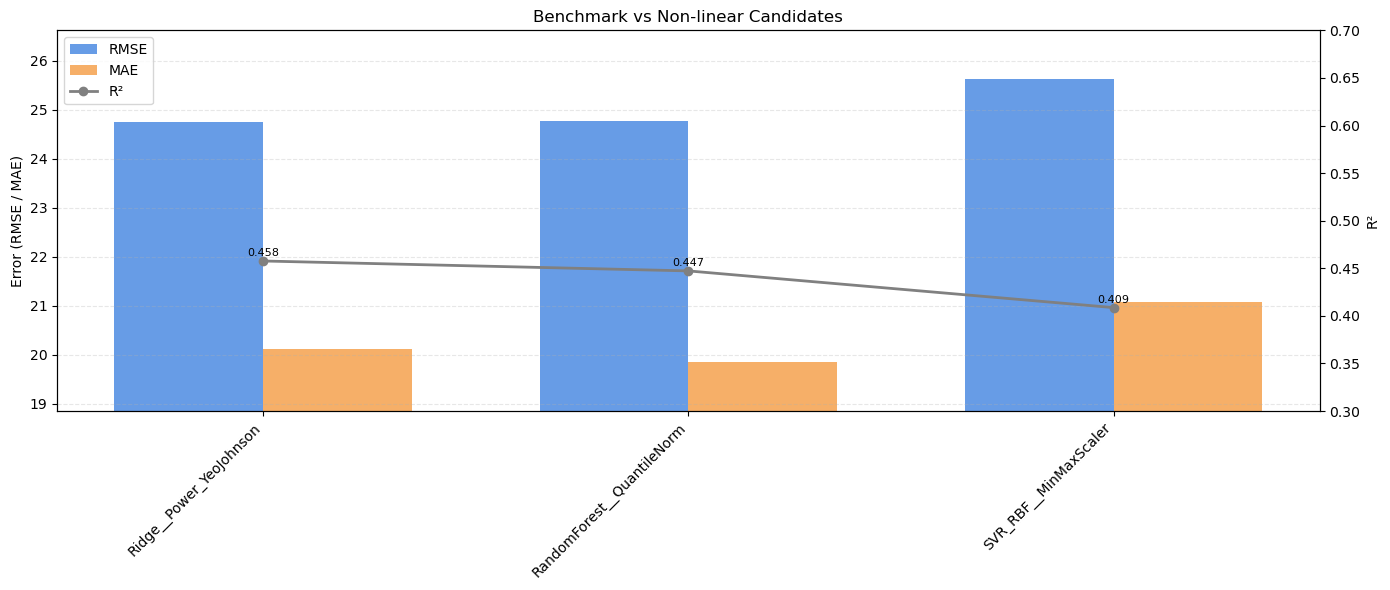

In [88]:
Plot_Res(
    summary_df,
    title="Benchmark vs Non-linear Candidates",
    out_path=os.path.join("Figuredump", "Benchmark_vs_Candidates.png"),
)

Interstingly, with Kfold = 5 cross validation, for the case of the SVR, the train vs test RMSE and $R^2$ were recorded as 25.32 v 25.62 and 0.4242 v 0.4087. For the case of the RF, equally,  train vs test were observed as 9.267 v 24.765 and 0.9929 v 0.4473. Both of the non-linear models exhibited significant underperformance compared to the baseline Ridge model(24.75RMSE and 0.458 $R^2$). It was evident that the SVR was either significantly underfitted or the data volume was too small to properly generalise. On the conterary, the RF model were thoguht to be curretly overfitting against noise. Thus, it was concluded further comparison was required after hyper parameter tuning.

# Hyper parameter Tuning 

In [99]:
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
svr_param_grid = {
    "model__C": [1, 10, 100],
    "model__gamma": ["scale", 0.1, 0.01, 0.001],
    "model__epsilon": [0.1, 0.2],
}

rf_param_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [5, 10, 20, None],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
    "model__min_samples_leaf": [1, 3, 5],
}

In [105]:
svr_base = Final_candidate_models["SVR_RBF__MinMaxScaler"]

gs_svr = GridSearchCV(
    estimator=svr_base,
    param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv5,
    n_jobs=-1,
    return_train_score=True,
)

gs_svr.fit(X_features, Y_Lable)

print("SVR_RBF__MinMaxScaler GridSearch")
print("Best params:", gs_svr.best_params_)
print("Best CV RMSE:", -gs_svr.best_score_)


rf_base = Final_candidate_models["RandomForest__QuantileNorm"]

gs_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv5,
    n_jobs=-1,
    return_train_score=True,
)

gs_rf.fit(X_features, Y_Lable)
print()
print("RandomForest__QuantileNorm GridSearch")
print("Best params:", gs_rf.best_params_)
print("Best CV RMSE:", -gs_rf.best_score_)


SVR_RBF__MinMaxScaler GridSearch
Best params: {'model__C': 10, 'model__epsilon': 0.1, 'model__gamma': 'scale'}
Best CV RMSE: 24.285034794152278

RandomForest__QuantileNorm GridSearch
Best params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}
Best CV RMSE: 24.519230418751285


In [ ]:
best_svr = gs_svr.best_estimator_
best_rf  = gs_rf.best_estimator_

res_svr = eval_model(
    name="SVR_RBF__MinMaxScaler (tuned)",
    md=best_svr,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te,
)

res_rf = eval_model(
    name="RandomForest__QuantileNorm (tuned)",
    md=best_rf,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te,
)

import pandas as pd

final_tuned_df = pd.DataFrame([res_svr, res_rf]).set_index("Model")
print(final_tuned_df.round(3))


                                    Train_RMSE  Train_MAE  Train_R2  \
Model                                                                 
SVR_RBF__MinMaxScaler (tuned)           23.123     17.824     0.518   
RandomForest__QuantileNorm (tuned)      12.051      9.428     0.869   

                                    Train_Spearman  Test_RMSE  Test_MAE  \
Model                                                                     
SVR_RBF__MinMaxScaler (tuned)                0.724     23.608    18.598   
RandomForest__QuantileNorm (tuned)           0.951     24.110    19.388   

                                    Test_R2  Test_Spearman  
Model                                                       
SVR_RBF__MinMaxScaler (tuned)         0.507          0.714  
RandomForest__QuantileNorm (tuned)    0.486          0.692  


After hyperparameter tuning using 5-fold cross-validation the RBF–SVR + MinMaxScaler showed the most consistent improvement across all test metrics. Its optimised configuration (C=10, ε=0.1, γ="scale") achieved a test RMSE of 23.61, outperforming both the tuned RF and the linear Ridge baseline(24.11 / 24.76). 

Moreover, the SVR continued to provided the highest rank correlation as shown in the spearman 0.714 demonstrating the capacity of the model to capture relationship of the data more effectively than the linear model(0.6893) or the RF model(0.692).  For the case of the RF, regardless to the exceedingly accurate train performance, due to unresolved overfitting issues. The test performance was observed to onlyshow small improvements compared to the linear ridge model(Test RMSE 24.11 v 24.76) while the $R^2$ was reported to be larger compared to that of the linear model(0.486 v 0.457). Overall, it was concluded the SVR+MinMax model was the best inclass and was concluded to be the best model for this dataset.

In [103]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def compute_learning_curve_reg(
    model,
    X,
    y,
    cv,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
):
    ts_abs, tr_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
    )
    tr_rmse = -tr_scores
    val_rmse = -val_scores

    return (
        ts_abs,
        tr_rmse.mean(axis=1),
        tr_rmse.std(axis=1),
        val_rmse.mean(axis=1),
        val_rmse.std(axis=1),
    )


def plot_learning_curve_rmse(
    train_sizes,
    tr_mean,
    tr_std,
    val_mean,
    val_std,
    title="Learning curve",
    out_path=None,
):
    plt.figure(figsize=(8, 5))

    plt.plot(train_sizes, tr_mean, label="Train RMSE")
    plt.fill_between(train_sizes, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)

    plt.plot(train_sizes, val_mean, label="CV RMSE")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()

    if out_path is not None:
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)

    plt.show()


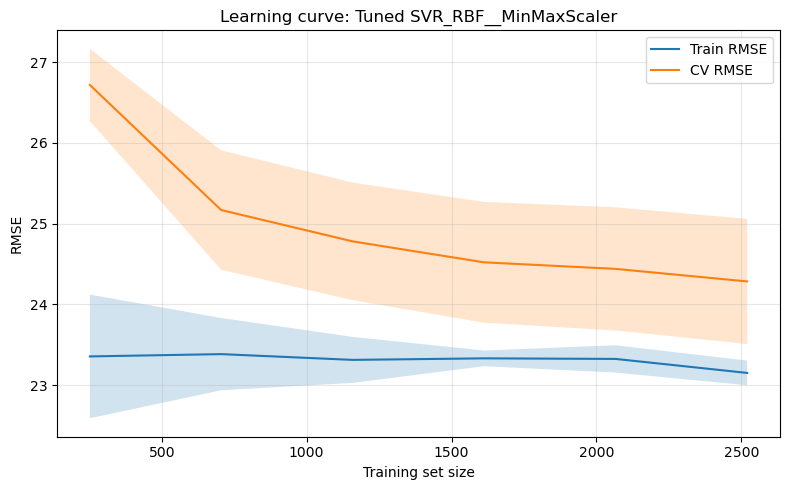

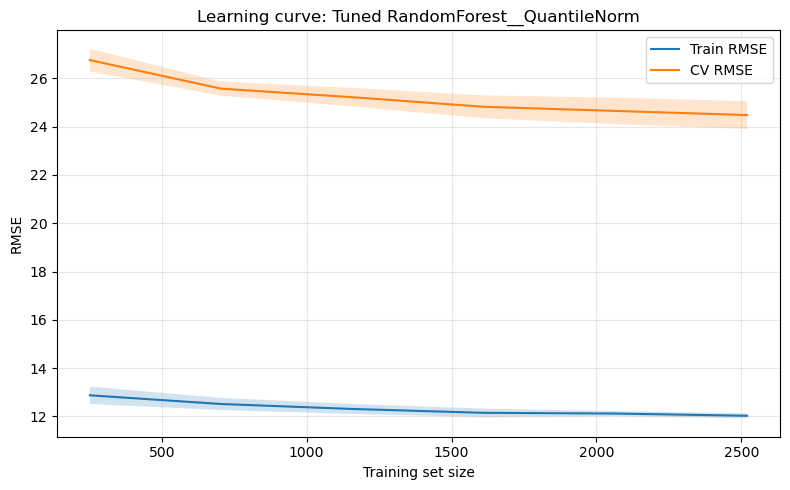

In [104]:
# SVR tuned learning curve
ts_svr, tr_m_svr, tr_s_svr, val_m_svr, val_s_svr = compute_learning_curve_reg(
    model=best_svr,
    X=X_features,
    y=Y_Lable,
    cv=cv5,
    train_sizes=np.linspace(0.1, 1.0, 6),
)

plot_learning_curve_rmse(
    train_sizes=ts_svr,
    tr_mean=tr_m_svr,
    tr_std=tr_s_svr,
    val_mean=val_m_svr,
    val_std=val_s_svr,
    title="Learning curve: Tuned SVR_RBF__MinMaxScaler",
    out_path=os.path.join("Figuredump", "LC_Tuned_SVR_RBF_MinMax.png"),
)


# RandomForest tuned learning curve
ts_rf, tr_m_rf, tr_s_rf, val_m_rf, val_s_rf = compute_learning_curve_reg(
    model=best_rf,
    X=X_features,
    y=Y_Lable,
    cv=cv5,
    train_sizes=np.linspace(0.1, 1.0, 6),
)

plot_learning_curve_rmse(
    train_sizes=ts_rf,
    tr_mean=tr_m_rf,
    tr_std=tr_s_rf,
    val_mean=val_m_rf,
    val_std=val_s_rf,
    title="Learning curve: Tuned RandomForest__QuantileNorm",
    out_path=os.path.join("Figuredump", "LC_Tuned_RF_QNorm.png"),
)


In [ ]:
target_models = ["Ridge__Power_YeoJohnson", "Ridge__QuantileNorm"]
pre_cv = df.loc[target_models].filter(like="Test_")
new_index = {}

for old in pre_cv.index:
    name = old.replace("Ridge__", "")
    new_index[old] = name
pre_cv = pre_cv.rename(index=new_index)

post_cv = initial_model_post_validation_raw.filter(like="_mean")

new_index = {}

for old in post_cv.index:
    name = old.replace("Ridge__", "") + "_postCV"
    new_index[old] = name
    post_cv = post_cv.rename(index=new_index)

new_cols = {c: c.replace("_mean", "") for c in post_cv.columns}
post_cv = post_cv.rename(columns=new_cols)

combined = pd.concat([pre_cv, post_cv], axis=0).sort_index()
plot_bar(combined, title = "Figure3 Comparison of crossvalidation(k=5)",
         savepath="Figuredump/Figure 3 Crossvalidation results.png",xrotation=0,)


In [ ]:
MvS_Sweep_sorted.head(10).round(3) - screen 1

round2_CV                           = CV 2 